In [1]:
# ------- SERVER EXTENSIONS ---------
lib =  r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/utilities/droplet_dataset'
lib2 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/utilities'
lib3 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/data_analysis'
lib4 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy'
lib5 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/scripts'
import sys
sys.path.append(lib)
sys.path.append(lib2)
sys.path.append(lib3)
sys.path.append(lib4)
sys.path.append(lib5)
# ------- SERVER EXTENSIONS ---------import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.manifold import TSNE
import pickle
# from Bio.Cluster import kcluster
import os
import numpy as np
import yaml
import os
import pandas
from collections import Counter
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import sys
import seaborn as sns
# import pyclustering
import matplotlib.pylab as plt
import seaborn as sb
from os.path import join
plt.rcParams['figure.dpi'] = 400
import seaborn as sns
from utilities.general_helpers import sort_dic
from utilities.general_helpers import transpose

from shutil import copyfile
import matplotlib.pyplot as plt
import random


In [2]:
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}%'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)


In [3]:
# tumor_path = r'/storage/md_keren/shitay/Data/droplet_seq/cohort/normalized/5.21/cohort_normalized_24.5.21.pkl'
COHORT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/cohort/normalized/6.21/cohort_normalized_10.6.21.pkl'

# tumor_cohort = pickle.load(open(tumor_path, 'rb'))
cohort = pickle.load(open(COHORT_PATH, 'rb'))
tumor_cohort = cohort.filter_cells_by_property('is_cancer', True)



In [4]:
TSNE_PATH = r'/storage/md_keren/shitay/outputs/TSNE/cohort_10.6.21/tumor_cells_bhtsne_14.6.21.pkl'
cells_embedded = pickle.load(open(TSNE_PATH, 'rb'))


# tsne_results = pd.DataFrame(cells_embedded, index=tumor_cohort.barcodes, columns=['TSNE1', 'TSNE2'])
index = [tumor_cohort.samples[i]+"_"+tumor_cohort.barcodes[i] for i in range(tumor_cohort.number_of_cells)]
tsne_results = pd.DataFrame(cells_embedded, index=index, columns=['TSNE1', 'TSNE2']) 

In [88]:
EXEC_DIR = r'/storage/md_keren/shitay/outputs/cNMF/executions/tumor_runs/cohort_10.6.21'
# selected_K = 18
local_density_threshold = '0.10'
number_of_genes=2000
n_replicates = 10
RUN_Ks = f'k15_25'

for selected_K in range(17, 18):
    RUN_NAME = f'{RUN_Ks}_{number_of_genes}genes_{n_replicates}iter'
    USAGES_CONSENSUS_FILE = f'{RUN_NAME}.usages.k_{selected_K}.dt_{str(local_density_threshold).replace(".", "_")}.consensus.txt'


    usage_matrix = pd.read_csv(join(EXEC_DIR, RUN_NAME, USAGES_CONSENSUS_FILE), sep='\t', index_col=0)
    usage_matrix.columns = np.arange(1,selected_K+1)
    normalized_usage_matrix = usage_matrix.div(usage_matrix.sum(axis=1), axis=0)
    normalized_usage_matrix.head()


    fig, axs = plt.subplots(int(np.ceil(selected_K/5)), 5)
    axs = axs.ravel()

    fig.set_size_inches(32, 22)
    for idx, (columnName, columnData) in enumerate(normalized_usage_matrix.iteritems()):
    #     print('Program : ', columnName)
        programs_vals = columnData.values
        df = pd.DataFrame(np.round(programs_vals, 1),columns=['Usage'])
        g = sns.barplot(x="Usage", y="Usage", data=df, estimator=lambda x: len(x) / len(df) * 100, ax=axs[idx]);
        g.set(ylabel="% of the cells");
        g.set_title(f'Program {columnName}')
        show_values_on_bars(g)
    fig.tight_layout()
    if selected_K%5>0:
        for i in range(5-selected_K%5, 0, -1):
            axs[-i].remove()
    fig.savefig(fr'/storage/md_keren/shitay/outputs/cNMF/visualizations/k15_25/k{selected_K}_cell_usages.jpg')


In [160]:
EXEC_DIR = r'/storage/md_keren/shitay/outputs/cNMF/executions/tumor_runs/cohort_10.6.21'
# selected_K = 18
local_density_threshold = '0.10'
number_of_genes=2000
n_replicates = 10
RUN_Ks = f'k5_14'

first_k = 5
last_k = 14

for selected_K in range(first_k, last_k+1):
    RUN_NAME = f'{RUN_Ks}_{number_of_genes}genes_{n_replicates}iter'
    USAGES_CONSENSUS_FILE = f'{RUN_NAME}.usages.k_{selected_K}.dt_{str(local_density_threshold).replace(".", "_")}.consensus.txt'


    usage_matrix = pd.read_csv(join(EXEC_DIR, RUN_NAME, USAGES_CONSENSUS_FILE), sep='\t', index_col=0)
    usage_matrix.columns = np.arange(1,selected_K+1)
    normalized_usage_matrix = usage_matrix.div(usage_matrix.sum(axis=1), axis=0)
    normalized_usage_matrix.head()

    tsne_and_usages = pd.merge(left=normalized_usage_matrix, right=tsne_results, left_index=True, right_index=True)

    programs_dfs = {}

    for column in normalized_usage_matrix.columns:

        programs_vals = np.round(normalized_usage_matrix[column].values, 1)
        curr_program_usage = pd.DataFrame([x/10 for x in range(11)], columns=['Usage'])
        curr_program_usage['val'] = curr_program_usage['Usage'].apply(lambda x: (sum(programs_vals>=x)/len(programs_vals))*100)
        programs_dfs[column] = curr_program_usage
    programs_dfs = {k: v for k, v in sorted(programs_dfs.items(), key=lambda item: item[1].iloc[1].val, reverse=True)}

    fig, axs = plt.subplots(int(np.ceil(selected_K/5)), 5)
    axs = axs.ravel()

    fig.set_size_inches(32, 22)
    for idx, (columnName, program_df) in enumerate(programs_dfs.items()):
        g = sns.barplot(x="Usage", y="val", data=program_df, ax=axs[idx])#, estimator=lambda x: len(x) / len(df) * 100, ax=axs[idx]);    
        g.set(ylabel="% of the cells");
        g.set_title(f'Program {columnName}')
        show_values_on_bars(g)
    fig.tight_layout()
    if selected_K%5>0:
        for i in range(5-selected_K%5, 0, -1):
            axs[-i].remove()
    fig.savefig(fr'/storage/md_keren/shitay/outputs/cNMF/visualizations/k15_25/plot2/k{selected_K}_cell_usages.jpg')

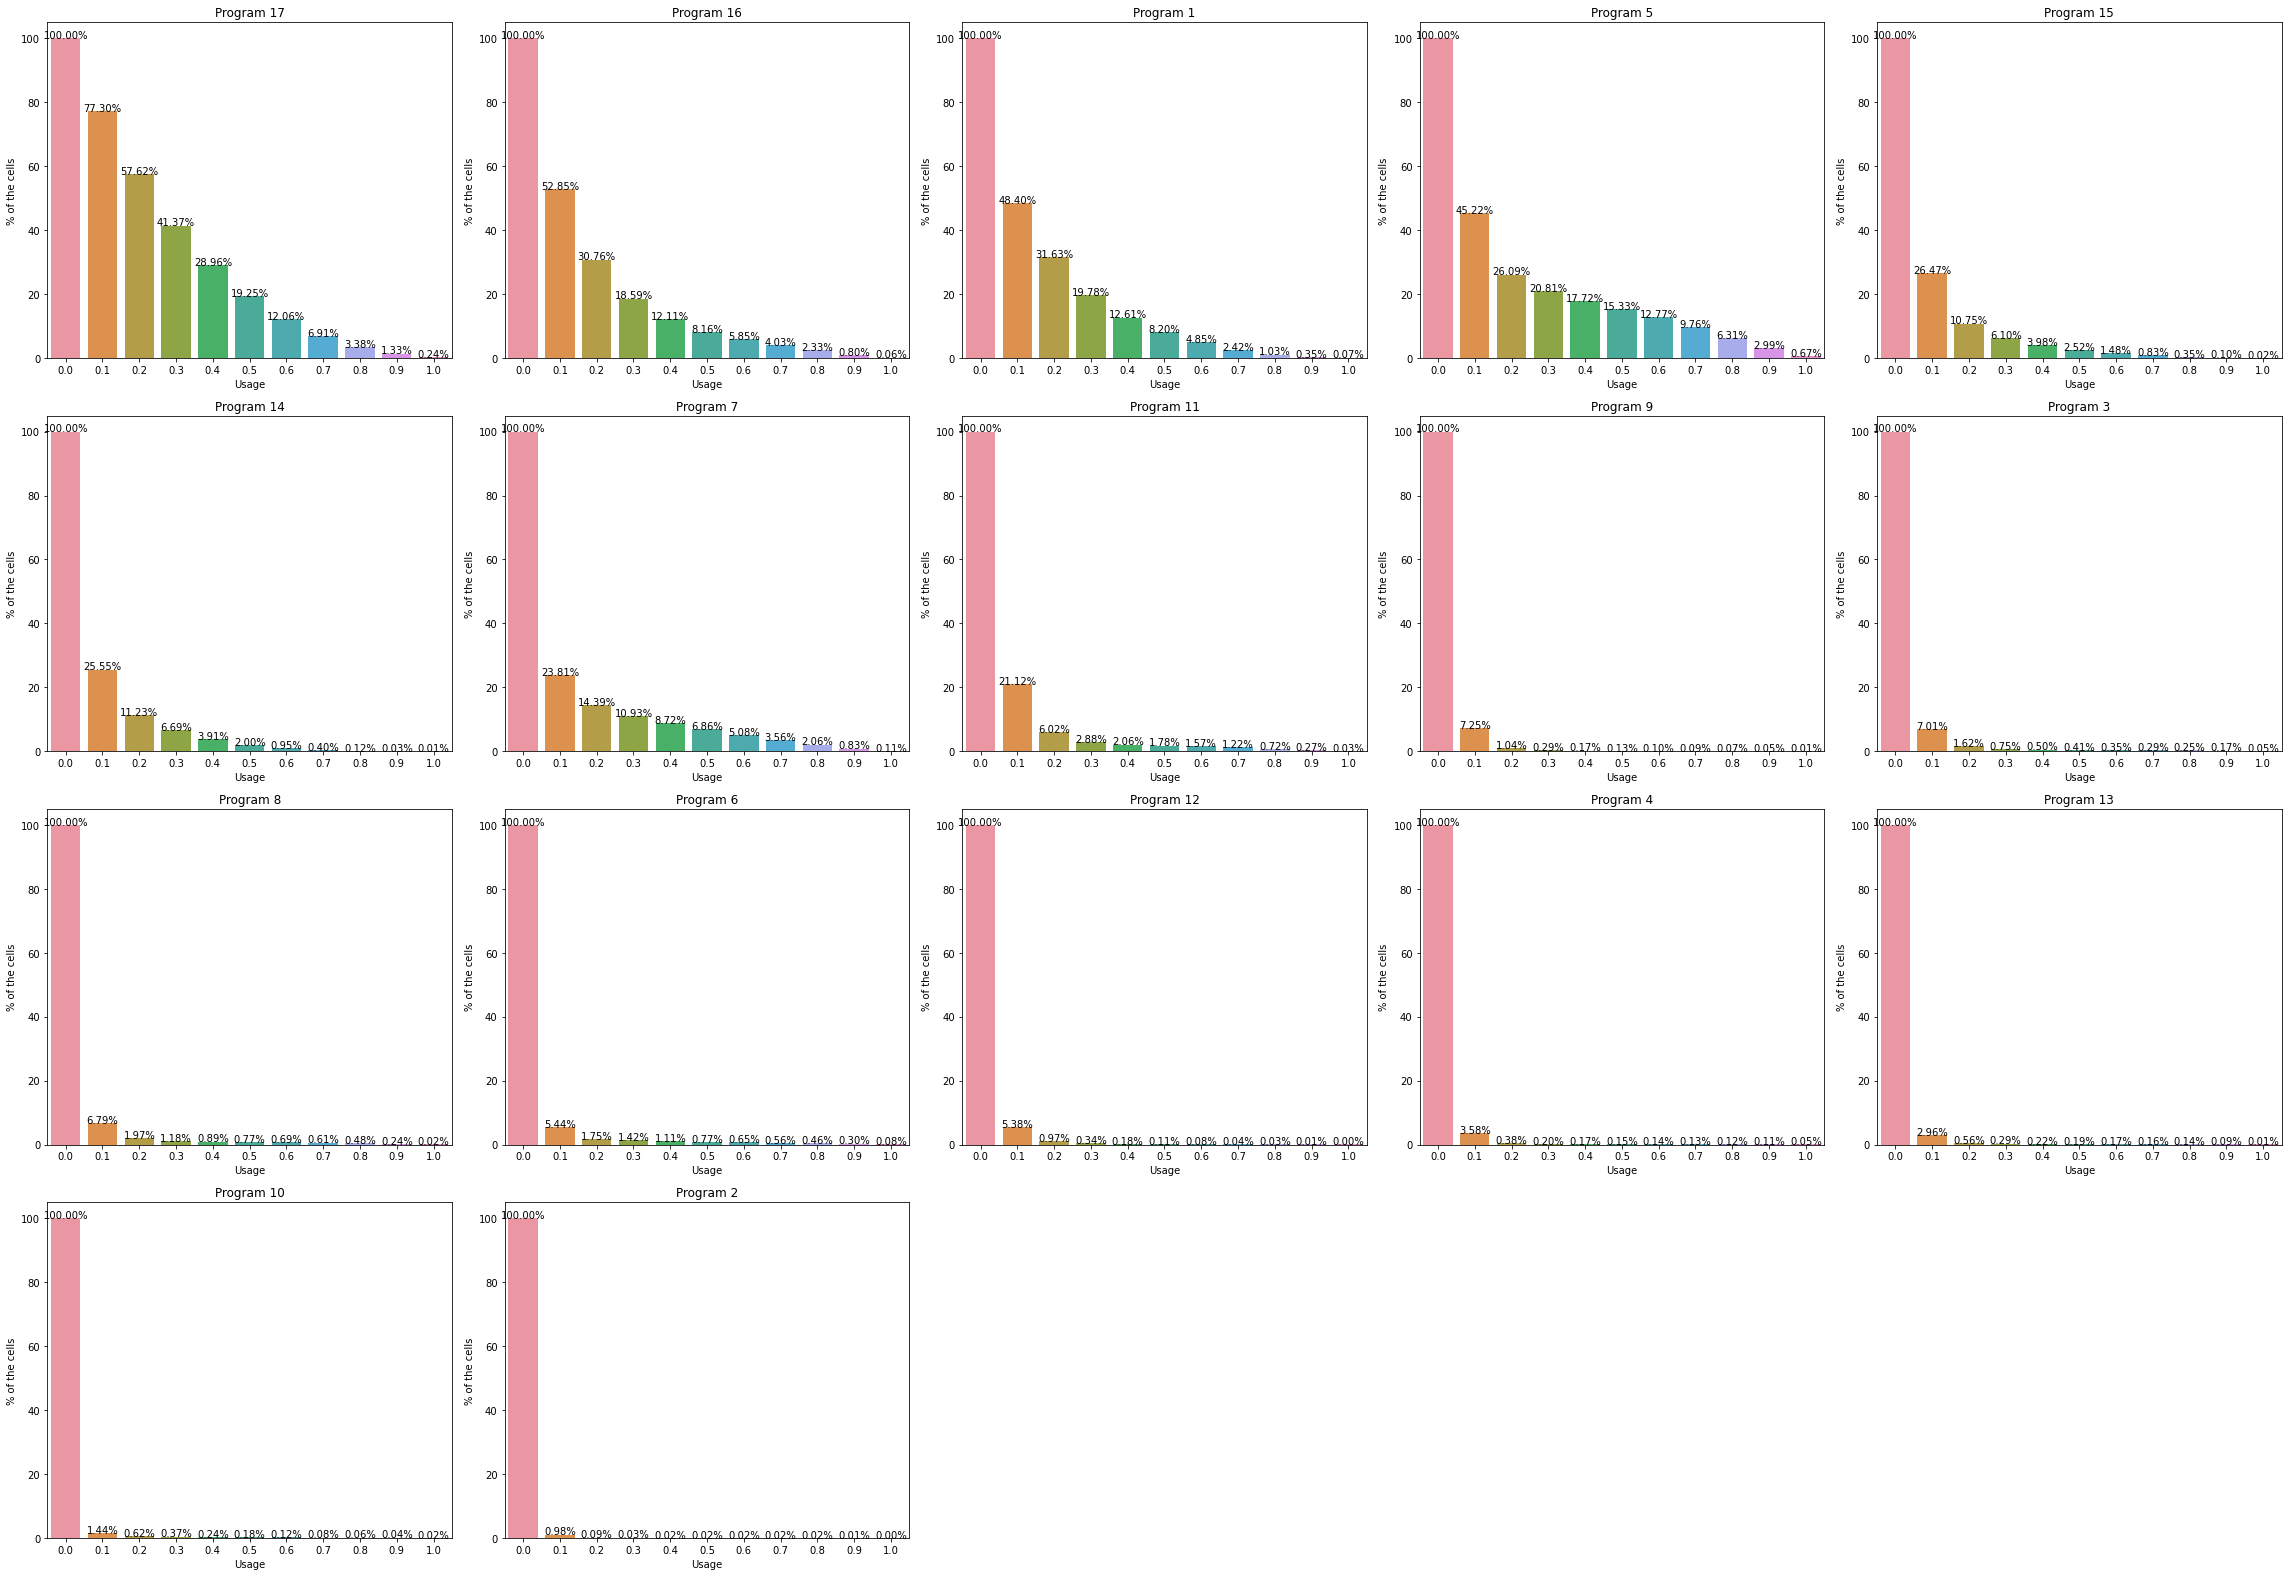

In [156]:
programs_dfs = {}

for column in normalized_usage_matrix.columns:

    programs_vals = np.round(normalized_usage_matrix[column].values, 1)
    curr_program_usage = pd.DataFrame([x/10 for x in range(11)], columns=['Usage'])
    curr_program_usage['val'] = curr_program_usage['Usage'].apply(lambda x: (sum(programs_vals>=x)/len(programs_vals))*100)
    programs_dfs[column] = curr_program_usage
programs_dfs = {k: v for k, v in sorted(programs_dfs.items(), key=lambda item: item[1].iloc[1].val, reverse=True)}

fig, axs = plt.subplots(int(np.ceil(selected_K/5)), 5)
axs = axs.ravel()

fig.set_size_inches(32, 22)
for idx, (columnName, program_df) in enumerate(programs_dfs.items()):
    g = sns.barplot(x="Usage", y="val", data=program_df, ax=axs[idx])#, estimator=lambda x: len(x) / len(df) * 100, ax=axs[idx]);    
    g.set(ylabel="% of the cells");
    g.set_title(f'Program {columnName}')
    show_values_on_bars(g)
fig.tight_layout()
if selected_K%5>0:
    for i in range(5-selected_K%5, 0, -1):
        axs[-i].remove()
# fig.savefig(fr'/storage/md_keren/shitay/outputs/cNMF/visualizations/k15_25/k{selected_K}_cell_usages.jpg')

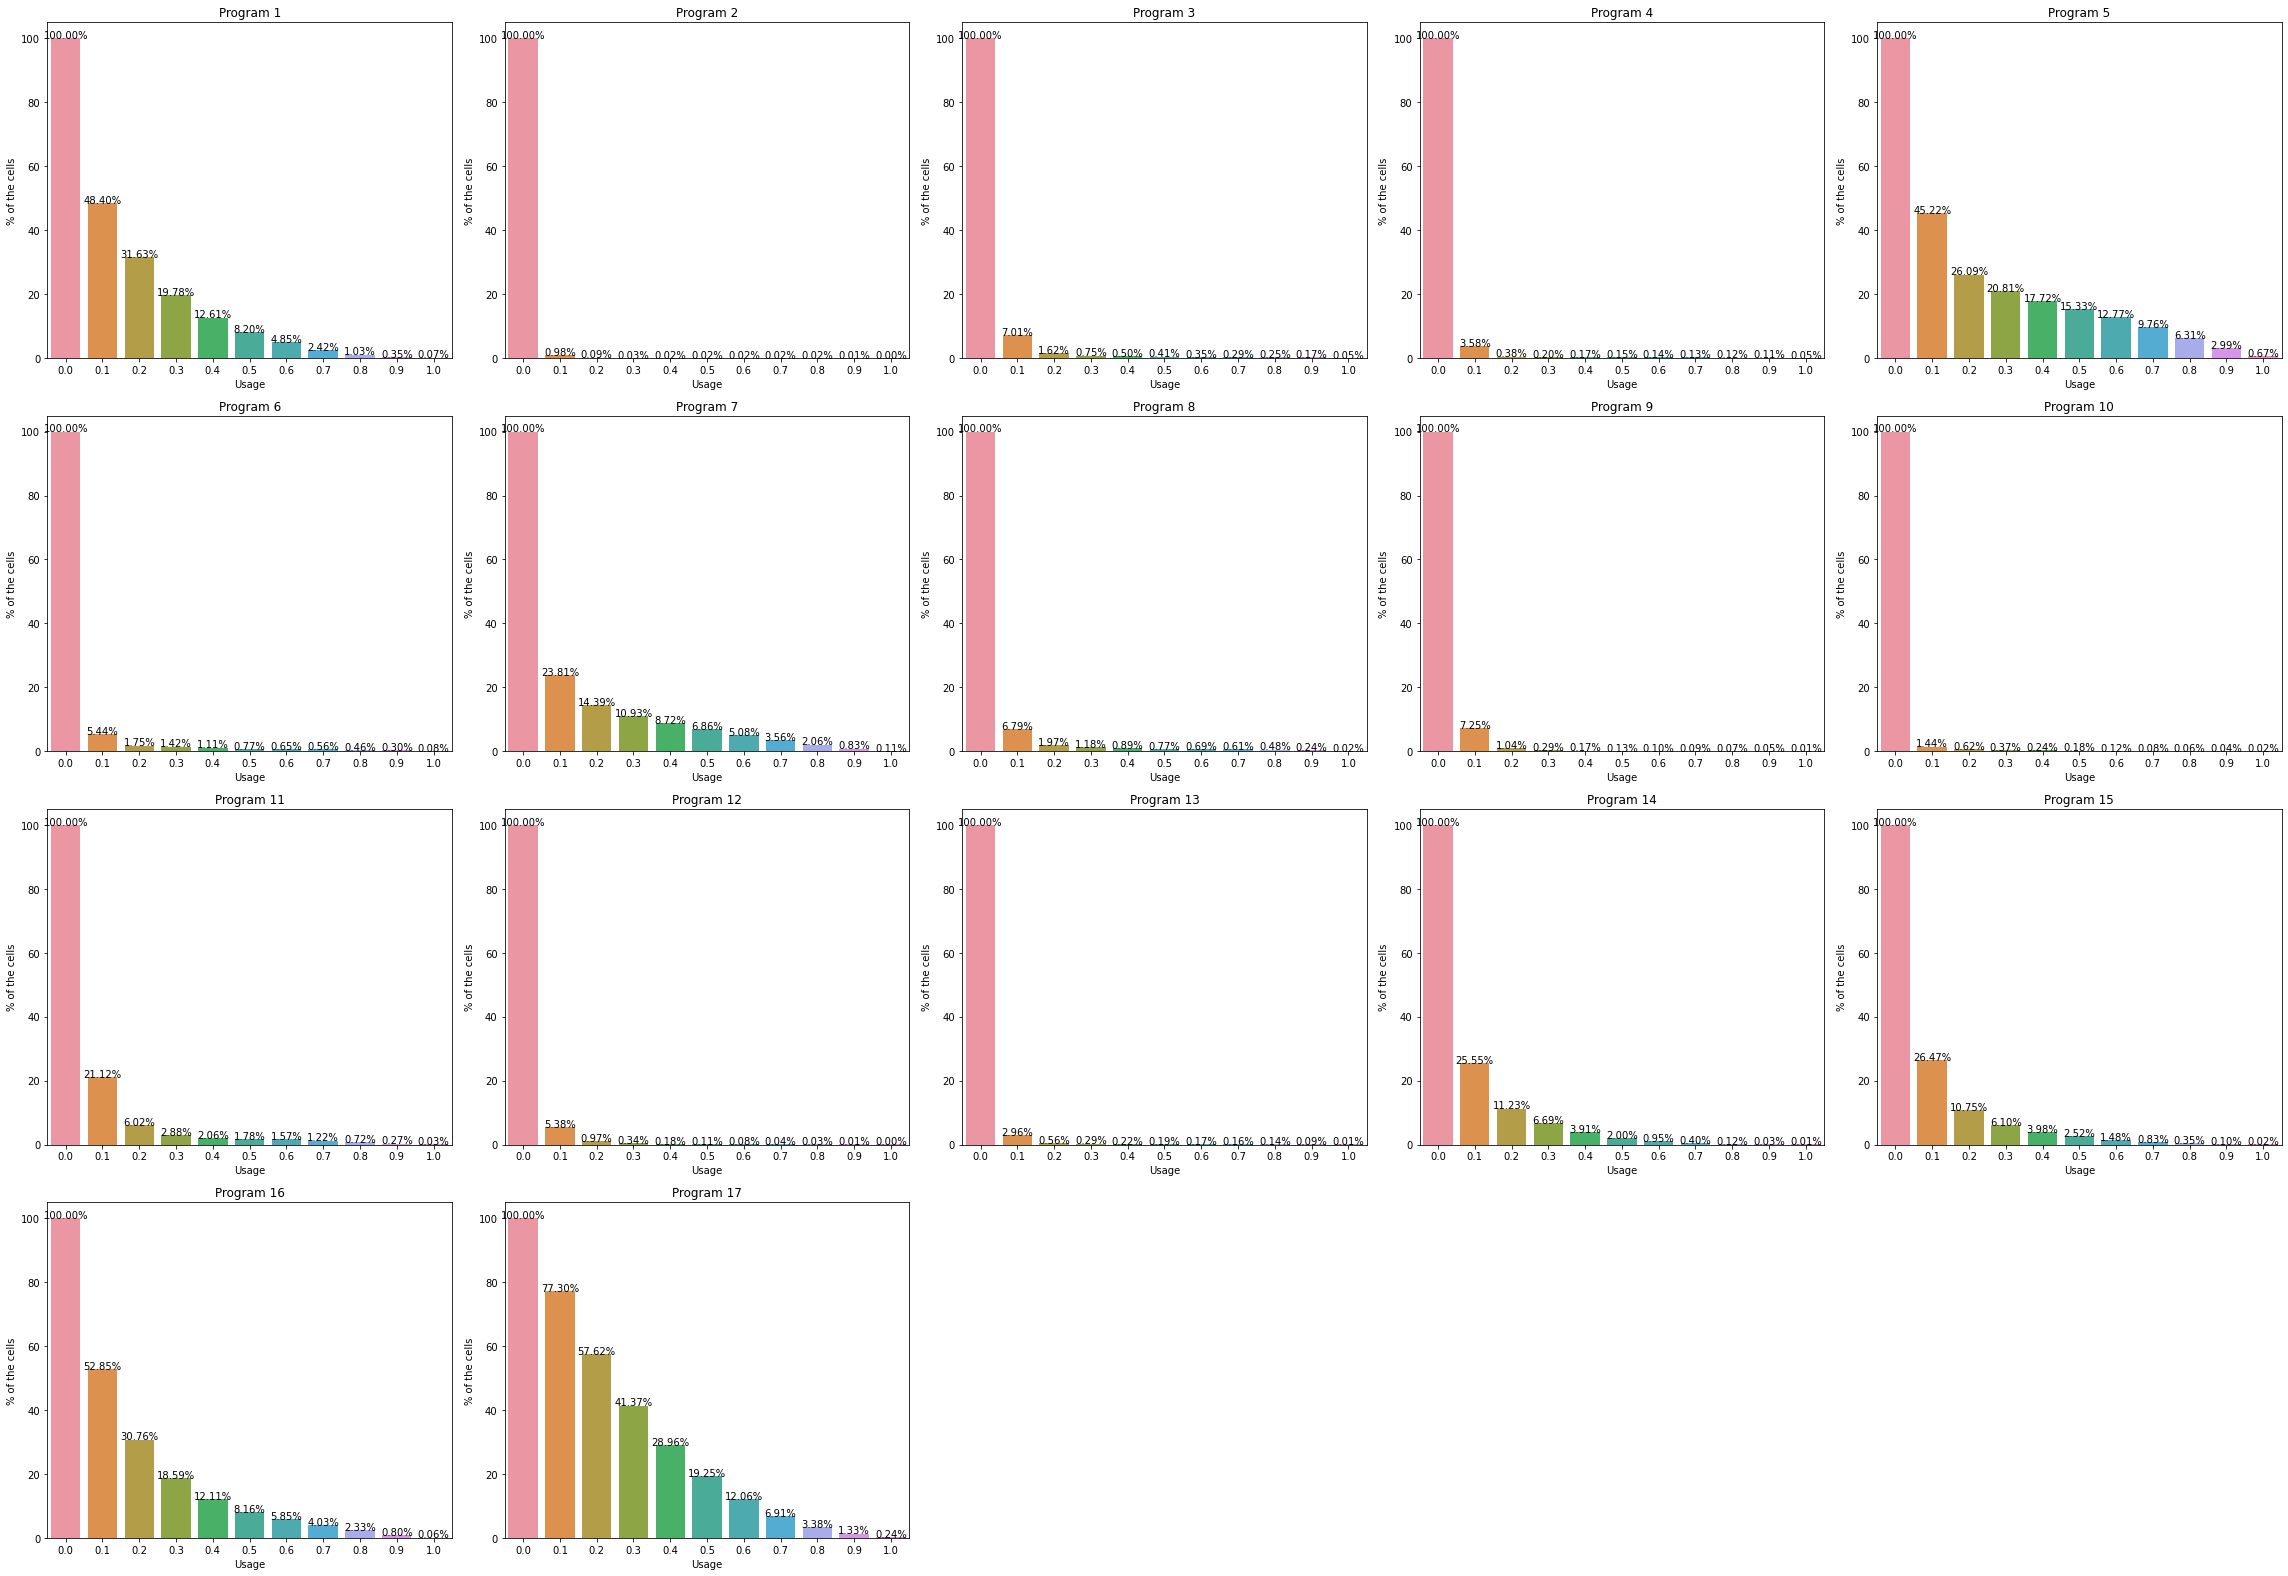

In [154]:
fig, axs = plt.subplots(int(np.ceil(selected_K/5)), 5)
axs = axs.ravel()

fig.set_size_inches(32, 22)
for idx, (columnName, columnData) in enumerate(normalized_usage_matrix.iteritems()):
#     print('Program : ', columnName)
    programs_vals = columnData.values
    df = pd.DataFrame(np.round(programs_vals, 1),columns=['Usage'])
    
    dd = pd.DataFrame([x/10 for x in range(11)], columns=['Usage'])
    dd['val'] = dd['Usage'].apply(lambda x: sum(df['Usage']>=x)/len(df)*100)
    g = sns.barplot(x="Usage", y="val", data=dd, ax=axs[idx])#, estimator=lambda x: len(x) / len(df) * 100, ax=axs[idx]);
    
    
    g.set(ylabel="% of the cells");
    g.set_title(f'Program {columnName}')
    show_values_on_bars(g)
fig.tight_layout()
if selected_K%5>0:
    for i in range(5-selected_K%5, 0, -1):
        axs[-i].remove()
# fig.savefig(fr'/storage/md_keren/shitay/outputs/cNMF/visualizations/k15_25/k{selected_K}_cell_usages.jpg')

# Debug

In [5]:
first_k = 5
last_k = 25

Ks_programs_df = []

for selected_K in range(first_k, last_k+1):
    if selected_K<15:
        RUN_Ks = f'k5_14'
    else:
        RUN_Ks = f'k15_25'

    
    RUN_NAME = f'{RUN_Ks}_{number_of_genes}genes_{n_replicates}iter'
    USAGES_CONSENSUS_FILE = f'{RUN_NAME}.usages.k_{selected_K}.dt_{str(local_density_threshold).replace(".", "_")}.consensus.txt'


    usage_matrix = pd.read_csv(join(EXEC_DIR, RUN_NAME, USAGES_CONSENSUS_FILE), sep='\t', index_col=0)
    usage_matrix.columns = np.arange(1,selected_K+1)
    normalized_usage_matrix = usage_matrix.div(usage_matrix.sum(axis=1), axis=0)
    normalized_usage_matrix.head()


    programs_dfs = {}

    for column in normalized_usage_matrix.columns:

        programs_vals = np.round(normalized_usage_matrix[column].values, 1)
        curr_program_usage = pd.DataFrame([x/10 for x in range(11)], columns=['Usage'])
        curr_program_usage['val'] = curr_program_usage['Usage'].apply(lambda x: (sum(programs_vals>=x)/len(programs_vals))*100)
        programs_dfs[column] = curr_program_usage
    programs_dfs = {k: v for k, v in sorted(programs_dfs.items(), key=lambda item: item[1].iloc[1].val, reverse=True)}
    Ks_programs_df.append(programs_dfs)

NameError: name 'number_of_genes' is not defined

In [ ]:
arr = np.array([[p.values[:,1].tolist() for p in list(programs_df.values())[:first_k]] for programs_df in Ks_programs_df])
# arr

In [ ]:
(arr[0] - arr[1])[0]

In [ ]:
pd.set_option('display.max_columns', None)

program_idx = 1 # ordered by mass, 0 is first
variable_usage = 1 # wich usage to take for comparison, starts with 1 - 1=0.1, 2=0.2, 3=0.3
metrix_size = last_k - first_k + 1

distances = np.zeros((metrix_size, metrix_size))
for i in range(metrix_size):
    for j in range(metrix_size):
        distances[i, j] = (arr[i] - arr[j])[program_idx][variable_usage]
pd.DataFrame(distances, columns = range(first_k, last_k+1), index = range(first_k, last_k+1))

P0 - [U0.1: (12-13), (20-21), (20-23)], [U0.2: (5-6), (12-13), (20-21)], [U0.3: (5-6), (5-8), (12-13), (20-21), (20-23)], [U0.4: (5-6), (5-8), (12-13), (15-16), (20-21), (20-23)]
Ks: 5, 12,20 (15)

P1 - [U0.1: (7-8)_,~(11-12), ~(11-13), (15-16)], [U0.2: ~(5-6), ~(5-8)

In [269]:
selected_K =24

25

In [264]:
GENE_SPECTRA_SCORE_PATH = f'{RUN_NAME}.gene_spectra_score.k_{selected_K}.dt_{str(local_density_threshold).replace(".", "_")}.txt'
gene_scores = pd.read_csv(join(EXEC_DIR, RUN_NAME, GENE_SPECTRA_SCORE_PATH), sep='\t', index_col=0)
gene_scores = gene_scores.T
gene_scores.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
TSPAN6,-0.000190,-0.000238,-0.000090,0.000688,-0.000180,0.000299,-0.000092,-0.000066,-0.000133,-0.000070,0.000276,0.000012,0.000055,-0.000187,-0.000396,-0.000070,0.000157,0.000949,-0.000154,0.000049,-0.000100,-0.000012,-0.000010,0.000663,-0.000286
TNMD,-0.000061,-0.000052,-0.000386,-0.000012,0.000106,0.000228,-0.000123,0.000002,-0.000004,0.000151,0.000032,0.000050,-0.000014,-0.000023,-0.000062,0.001292,0.000011,0.000034,0.000046,0.000053,-0.000124,-0.000055,0.000809,0.000025,-0.000168
DPM1,-0.000127,0.000120,-0.000009,-0.000047,-0.000049,-0.000044,0.000183,0.000012,0.000090,-0.000043,-0.000197,-0.000063,-0.000043,-0.000064,0.000044,0.000112,0.000800,0.001305,-0.000126,0.000570,-0.000809,-0.000013,-0.000088,-0.000156,-0.000415
SCYL3,0.000044,-0.000036,-0.000047,0.000101,0.000315,-0.000013,-0.000221,0.000022,-0.000022,-0.000035,-0.000089,0.000317,0.000011,0.000031,0.000003,0.000026,-0.000056,0.000613,-0.000102,0.000241,0.000185,-0.000146,-0.000059,-0.000148,-0.000277
C1orf112,-0.000062,-0.000138,-0.000043,-0.000054,0.000015,-0.000013,-0.000195,-0.000044,0.000018,-0.000064,-0.000492,-0.000090,0.001672,0.000189,0.000047,-0.000205,0.002224,0.001046,-0.000159,-0.000188,-0.000246,-0.000033,-0.000109,-0.000115,-0.000550


In [267]:


# topgenes.head(10)

In [298]:
programs_dfs[21]


,Usage,val
0,0.0,100.000000
1,0.1,60.687092
2,0.2,37.210654
3,0.3,23.843332
4,0.4,15.107447
5,0.5,9.439177
6,0.6,5.649211
7,0.7,3.201982
8,0.8,1.723924
9,0.9,0.776671


In [361]:
def overlap_size(l1, l2):
    return len([g for g in l1 if g in l2])


selected_K = 9
selected_K_2 = 8





topgenes = []
topgenes_2 = []
num_top_genes=250


# k_1
if selected_K<15:
    RUN_Ks = f'k5_14'
else:
    RUN_Ks = f'k15_25'
RUN_NAME = f'{RUN_Ks}_{number_of_genes}genes_{n_replicates}iter'
GENE_SPECTRA_SCORE_PATH = f'{RUN_NAME}.gene_spectra_score.k_{selected_K}.dt_{str(local_density_threshold).replace(".", "_")}.txt'
gene_scores = pd.read_csv(join(EXEC_DIR, RUN_NAME, GENE_SPECTRA_SCORE_PATH), sep='\t', index_col=0).T
for gep in gene_scores.columns:
    topgenes.append(pd.Series(gene_scores[gep].sort_values(ascending=False).index[:num_top_genes]))
topgenes = pd.concat(topgenes, axis=1)
topgenes.columns = ['GEP%d' % g for g in gene_scores.columns]

# k_1
if selected_K_2<15:
    RUN_Ks = f'k5_14'
else:
    RUN_Ks = f'k15_25'
RUN_NAME = f'{RUN_Ks}_{number_of_genes}genes_{n_replicates}iter'

GENE_SPECTRA_SCORE_PATH = f'{RUN_NAME}.gene_spectra_score.k_{selected_K_2}.dt_{str(local_density_threshold).replace(".", "_")}.txt'
gene_scores = pd.read_csv(join(EXEC_DIR, RUN_NAME, GENE_SPECTRA_SCORE_PATH), sep='\t', index_col=0).T
for gep in gene_scores.columns:
    topgenes_2.append(pd.Series(gene_scores[gep].sort_values(ascending=False).index[:num_top_genes]))
topgenes_2= pd.concat(topgenes_2, axis=1)
topgenes_2.columns = ['GEP%d' % g for g in gene_scores.columns]

overlaps_sizes = [[overlap_size(pi, pj) for pi in topgenes.values.T.tolist()] for pj in topgenes_2.values.T.tolist()]
pd.DataFrame(overlaps_sizes, columns=range(1,selected_K+1), index=range(1,selected_K_2+1))

,1,2,3,4,5,6,7,8,9
1,9,247,3,2,14,9,6,3,7
2,13,8,5,3,0,249,20,1,2
3,4,2,0,250,1,3,5,2,1
4,47,2,220,0,0,5,8,18,0
5,39,4,5,4,3,21,245,4,1
6,25,2,21,2,1,1,5,237,0
7,1,14,0,1,244,1,4,1,0
8,1,7,0,1,0,2,1,0,248


In [366]:
min(np.max(overlaps_sizes, axis=0))

47

In [391]:
def overlap_size(l1, l2):
    return len([g for g in l1 if g in l2])



for selected_K in range(5, 25):
    selected_K_2 = selected_K+1
    print(f'Comparing programs of {selected_K} and {selected_K_2}:')
    
    
    topgenes = []
    topgenes_2 = []
    num_top_genes=250


    # k_1
    if selected_K<15:
        RUN_Ks = f'k5_14'
    else:
        RUN_Ks = f'k15_25'
    RUN_NAME = f'{RUN_Ks}_{number_of_genes}genes_{n_replicates}iter'
    GENE_SPECTRA_SCORE_PATH = f'{RUN_NAME}.gene_spectra_score.k_{selected_K}.dt_{str(local_density_threshold).replace(".", "_")}.txt'
    gene_scores = pd.read_csv(join(EXEC_DIR, RUN_NAME, GENE_SPECTRA_SCORE_PATH), sep='\t', index_col=0).T
    for gep in gene_scores.columns:
        topgenes.append(pd.Series(gene_scores[gep].sort_values(ascending=False).index[:num_top_genes]))
    topgenes = pd.concat(topgenes, axis=1)
    topgenes.columns = ['GEP%d' % g for g in gene_scores.columns]

    # k_1
    if selected_K_2<15:
        RUN_Ks = f'k5_14'
    else:
        RUN_Ks = f'k15_25'
    RUN_NAME = f'{RUN_Ks}_{number_of_genes}genes_{n_replicates}iter'

    GENE_SPECTRA_SCORE_PATH = f'{RUN_NAME}.gene_spectra_score.k_{selected_K_2}.dt_{str(local_density_threshold).replace(".", "_")}.txt'
    gene_scores = pd.read_csv(join(EXEC_DIR, RUN_NAME, GENE_SPECTRA_SCORE_PATH), sep='\t', index_col=0).T
    for gep in gene_scores.columns:
        topgenes_2.append(pd.Series(gene_scores[gep].sort_values(ascending=False).index[:num_top_genes]))
    topgenes_2= pd.concat(topgenes_2, axis=1)
    topgenes_2.columns = ['GEP%d' % g for g in gene_scores.columns]

    overlaps_sizes = [[overlap_size(pi, pj) for pi in topgenes.values.T.tolist()] for pj in topgenes_2.values.T.tolist()]
#     pd.DataFrame(overlaps_sizes, columns=range(1,selected_K+1), index=range(1,selected_K_2+1))
    print(f'Min overlap value is: {min(np.max(overlaps_sizes, axis=0))}')
    pr_idx = np.argmin(np.max(overlaps_sizes, axis=0))+1
    print(f'the min value belongs to program num {pr_idx} of k={selected_K}\n')

Comparing programs of 5 and 6:
Min overlap value is: 113
the min value belongs to program num 5 of k=5

Comparing programs of 6 and 7:
Min overlap value is: 83
the min value belongs to program num 1 of k=6

Comparing programs of 7 and 8:
Min overlap value is: 98
the min value belongs to program num 2 of k=7

Comparing programs of 8 and 9:
Min overlap value is: 220
the min value belongs to program num 4 of k=8

Comparing programs of 9 and 10:
Min overlap value is: 188
the min value belongs to program num 5 of k=9

Comparing programs of 10 and 11:
Min overlap value is: 227
the min value belongs to program num 2 of k=10

Comparing programs of 11 and 12:
Min overlap value is: 207
the min value belongs to program num 11 of k=11

Comparing programs of 12 and 13:
Min overlap value is: 217
the min value belongs to program num 2 of k=12

Comparing programs of 13 and 14:
Min overlap value is: 153
the min value belongs to program num 11 of k=13

Comparing programs of 14 and 15:
Min overlap value 

In [388]:
# min(np.max(overlaps_sizes, axis=0))
print((np.max(overlaps_sizes, axis=0)))
print(min(np.max(overlaps_sizes, axis=0)))
np.argmin(np.max(overlaps_sizes, axis=0))+1

[248 248 247 248 245 244 250 249 234 249 250 249 243 250 246 250 247 243
 249 230 250  30 244 222]
30


22

In [382]:
pd.DataFrame(overlaps_sizes, columns=range(1,selected_K+1), index=range(1,selected_K_2+1))

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
1,3,4,6,3,4,14,1,32,5,0,0,10,2,2,1,1,8,0,1,35,250,2,0,5
2,2,32,5,14,7,32,2,6,1,8,2,7,13,3,9,0,247,12,4,0,8,13,5,10
3,2,2,21,6,33,3,5,3,93,0,0,18,21,4,7,1,10,1,1,0,5,30,3,222
4,23,1,15,8,1,0,2,4,4,1,250,2,1,2,1,54,3,0,0,5,0,1,1,2
5,0,0,4,0,4,4,250,0,4,1,2,4,5,0,1,4,2,0,1,0,1,5,5,4
6,4,2,13,4,25,7,4,3,16,1,2,249,3,1,2,1,7,1,0,7,10,13,4,17
7,4,248,2,7,3,21,0,3,2,3,1,2,7,2,8,0,32,12,4,0,5,1,18,3
8,248,4,14,12,3,2,0,6,6,1,23,4,4,3,0,2,2,2,0,2,4,2,2,3
9,13,6,10,248,0,1,0,1,4,0,7,4,6,12,1,3,15,0,0,11,3,4,0,7
10,14,2,247,10,10,2,4,3,33,0,14,13,9,1,1,8,6,3,0,5,6,7,3,22


In [371]:
# mapping = np.array([[idx+1, np.argmax(v)+1] for idx, v in enumerate(transpose(overlaps_sizes)) if np.max(v)>35])
# mapping

In [370]:
# mapping[np.array(programs_orders[0])-1]


In [367]:
# programs_orders = [list(K.keys()) for K in Ks_programs_df]
# programs_orders

In [369]:
# topgenes